# Setting Up Environment
We will be using Tensorflow 1.15.0


In [2]:
import tensorflow as tf
print( tf.__version__)

1.15.0


In [0]:
import os

from keras.utils import HDF5Matrix
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.xception import Xception
import tensorflow_datasets

import numpy as np
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support, accuracy_score
import random
import time

import seaborn as sns
import pandas as pd
import gc


In [4]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Uploading Data

We will be using the PatchCamelyon (PCam) dataset for a binary classification task. The ziped datasets can be obtained at https://github.com/basveeling/pcam.  **Copy the zipped datasets to your Google Drive** then follow the code below to mount your drive and unzip the files.

For efficiency when training, we will be using the PCam dataset saved tensorflow_datasets.  We run our final evaluations on data directly from the PCam repo.  **The datasets are idential.  We use data directly from the repo so we can have access to the raw data.**


**train:**262,144 examples

**test:** 32768 examples

**validation:** 32768 examples

In [0]:
%%shell
# Only Run Once**
# add write privilege for copies
chmod -R +w '/content/drive/My Drive/pcamv1_no_gz/'
ls -tl '/content/drive/My Drive/pcamv1_no_gz/'

total 7872279
-rw------- 1 root root       3038 Dec  2 23:07 camelyonpatch_level_2_split_valid_y.h5.gz
-rw------- 1 root root  805965320 Dec  2 23:07 camelyonpatch_level_2_split_valid_x.h5.gz
-rw------- 1 root root    1850810 Dec  2 23:07 camelyonpatch_level_2_split_valid_meta.csv
-rw------- 1 root root      21378 Dec  2 23:07 camelyonpatch_level_2_split_train_y.h5.gz
-rw------- 1 root root 6421353462 Dec  2 23:06 camelyonpatch_level_2_split_train_x.h5.gz
-rw------- 1 root root   15047830 Dec  2 23:06 camelyonpatch_level_2_split_train_meta.csv
-rw------- 1 root root   14482351 Dec  2 23:06 camelyonpatch_level_2_split_train_mask.h5.gz
-rw------- 1 root root       3040 Dec  2 23:06 camelyonpatch_level_2_split_test_y.h5.gz
-rw------- 1 root root  800875929 Dec  2 23:06 camelyonpatch_level_2_split_test_x.h5.gz
-rw------- 1 root root    1608584 Dec  2 23:06 camelyonpatch_level_2_split_test_meta.csv


In [0]:
# Only Run Once**
# unzip files in drive
%%shell
gunzip -r '/content/drive/My Drive/pcamv1_no_gz'

The dataset has now been downloaded in Google Drive, decompressed, and stored in `/content/drive/My Drive/pcamv1_no_gz/` and `/content/pcamv1_no_gz/`.

Open the `h5` files using `HDF5Matrix.`

In [0]:
# import the pictures
DATA_DIR = "/content/drive/My Drive/pcamv1_no_gz"

#we don't need training data, we use tensorflow's PCam pre-saved
#x_train = HDF5Matrix(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_train_x.h5'), 'x')
#y_train = HDF5Matrix(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_train_y.h5'), 'y')

x_test  = HDF5Matrix(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_test_x.h5'), 'x')
y_test  = HDF5Matrix(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_test_y.h5'), 'y')

In [0]:
# import the labels
train_data_frame = pd.read_csv(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_train_meta.csv'))
test_data_frame = pd.read_csv(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_test_meta.csv'))
valid_data_frame = pd.read_csv(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_valid_meta.csv'))

In [0]:
#load in dataset object of PCam data
pcam, pcam_info = tensorflow_datasets.load("patch_camelyon", with_info=True)

In [54]:
print(pcam_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=0.1.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.
',
    urls=['https://patchcamelyon.grand-challenge.org/'],
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_2

## Data Overview
Basic Code for investigating the datasets.

[[[0]]]


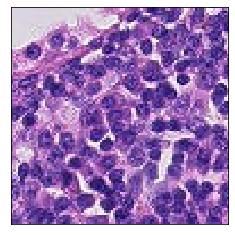

In [0]:
# print the first example in training set
ax = plt.subplot(1, 1, 1)
imshow(x_test[0])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
print(y_train[0])

In [0]:
# Class Label Distributions
print(train_data_frame['center_tumor_patch'].value_counts())
print(test_data_frame['center_tumor_patch'].value_counts())
print(valid_data_frame['center_tumor_patch'].value_counts())

True     131072
False    131072
Name: center_tumor_patch, dtype: int64
False    16391
True     16377
Name: center_tumor_patch, dtype: int64
False    16399
True     16369
Name: center_tumor_patch, dtype: int64


# New Data 

# Baseline CNN

We'll first train a CNN from scratch.  


**Model Architecture:**

Three pairs of convolutional layers with strides left to the default of 1 (veritically and horizonatally).  No padding is applied (because classification is dependent only on the center pixels).  Batch normalization is applied after each pair of convolutional layers.




In [0]:
# create tensorflow and numpy random seeds
np.random.seed(122)
tf.set_random_seed(6547)

# create shortcut 
tfkl = tf.keras.layers

In [96]:
#The CNN Baseline Model

cnn_baseline = tf.keras.Sequential(
    [
      tfkl.InputLayer(input_shape=(96, 96, 3)),
     
      #convolution layers
      tfkl.Conv2D(16, (3, 3), activation='relu'),
      tfkl.Conv2D(16, (3, 3), activation='relu'),
      tfkl.BatchNormalization(axis=-1),
      tfkl.MaxPooling2D((2, 2), strides=(2,2)),

      tfkl.Conv2D(32, (3, 3), activation='relu'),
      tfkl.Conv2D(32, (3, 3), activation='relu'),
      tfkl.BatchNormalization(axis=-1),
      tfkl.MaxPooling2D((2, 2), strides=(2,2)),

      tfkl.Conv2D(64, (3, 3), activation='relu'),
      tfkl.Conv2D(64, (3, 3), activation='relu'),
      tfkl.BatchNormalization(axis=-1),
      tfkl.MaxPooling2D((2, 2), strides=(2,2)),

      #dense layers
      tfkl.Flatten(),
      tfkl.Dense(32, activation='relu'),
      tfkl.Dropout(rate=0.2),
      tfkl.Dense(16, activation='relu'),
      tfkl.Dropout(rate=0.2),
      tfkl.Dense(1, activation='sigmoid'),   
    ] )

adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_baseline.compile(optimizer=adam_opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn_baseline.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 92, 92, 16)        2320      
_________________________________________________________________
batch_normalization_18 (Batc (None, 92, 92, 16)        64        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 44, 44, 32)        4640      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 42, 42, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 42, 42, 32)       

In [0]:
# train the model with early stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto')

In [0]:
# need to transform and augment the data before feeding into model
def clean_example(example):
    image, label = example['image'], example['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)

    # some basic data augmentation
    image = tf.image.random_flip_left_right(image, seed=random.seed(time.time()) )
    image = tf.image.random_flip_up_down(image, seed=random.seed(time.time()) )

    return image, label

In [0]:
#set batch size
train_batch = 256
valid_batch = 128

#set up pipelne for tf.data.datasets for the train and validation data (test data we'll look at later)
train_pipeline = pcam['train'].map(clean_example,
                                   num_parallel_calls=8).repeat().batch(train_batch).prefetch(2)
valid_pipeline = pcam['validation'].map(clean_example,
                                        num_parallel_calls=8).repeat().batch(test_batch).prefetch(2)

In [97]:
cnn_baseline_history = cnn_baseline.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 callbacks=[early_stopping],
                 shuffle = True,
                 epochs=5, 
                 steps_per_epoch = 262144 // train_batch,
                 validation_steps=256)

Train on 1024 steps, validate on 256 steps
Epoch 1/5
1024/1024 [==============================] - 253s 247ms/step - loss: 0.3829 - acc: 0.8363 - val_loss: 0.4692 - val_acc: 0.8047
Epoch 2/5
1024/1024 [==============================] - 248s 243ms/step - loss: 0.2878 - acc: 0.8849 - val_loss: 0.4953 - val_acc: 0.8231
Epoch 3/5
1024/1024 [==============================] - 249s 243ms/step - loss: 0.2450 - acc: 0.9056 - val_loss: 0.4471 - val_acc: 0.8223
Epoch 4/5
1024/1024 [==============================] - 248s 242ms/step - loss: 0.2178 - acc: 0.9173 - val_loss: 0.3579 - val_acc: 0.8508
Epoch 5/5
1024/1024 [==============================] - 254s 248ms/step - loss: 0.2017 - acc: 0.9245 - val_loss: 0.3301 - val_acc: 0.8649


In [0]:
# save the model as h5 file in google drive
# Only do this once **
cnn_baseline.save('/content/drive/My Drive/models/baseline_model.h5')

# read in model
# cnn_baseline = tf.keras.models.load_model('/content/drive/My Drive/models/baseline_model.h5')

In [99]:
#This helps clean the RAM after training
gc.collect()

6795

### Model Perfomance
An overview of how the baseline models performed.

#### Train and Validation Performance

First, let's see how the model trained.

In [0]:
#create functions for metric evautions + loss plotting
def plot_loss(results_hist):
  plt.plot(results_hist.history['loss'])
  plt.plot(results_hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()

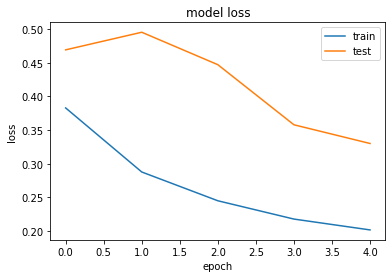

In [101]:
# Loss plot -- Doesn't appear to be overfitting
plot_loss(cnn_baseline_history)

#### Test Performance

Next, let's see how well the model performs of the test data.

In [0]:
# predit with model on validation set
sample_data_generator =  ImageDataGenerator(
              preprocessing_function=lambda x: x/255.)

test_predictions = cnn_baseline.predict_generator(sample_data_generator.flow(x_test, batch_size=64, shuffle=False))

In [103]:
y_pred = test_predictions.flatten() > 0.5

# conf. matrix
print(confusion_matrix(y_test[:].flatten(), y_pred) )

#prec. recall f1
metrics_array = precision_recall_fscore_support(y_test[:].flatten(), y_pred)

print(f"prec. of 0: {metrics_array[0][0]}")
print(f"prec. of 1: {metrics_array[0][1]}")

print(f"recall of 0: {metrics_array[1][0]}")
print(f"recall of 1: {metrics_array[1][1]}")

acc = accuracy_score(y_test[:].flatten(), y_pred)
print(f"accuracy: {acc}")


[[14298  2093]
 [ 3731 12646]]
prec. of 0: 0.7930556325919352
prec. of 1: 0.8579957934730986
recall of 0: 0.8723079738881093
recall of 1: 0.7721804970385296
accuracy: 0.822265625


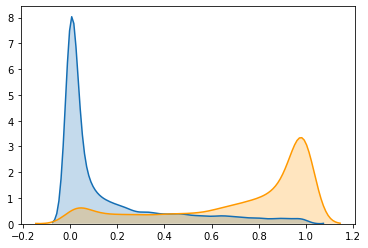

In [104]:
#create dataframe
df_test = pd.DataFrame({'actual':y_test[:].flatten(), 'probabilities':test_predictions.flatten()})

#Class probability distributions
p1=sns.kdeplot(df_test.probabilities[df_test.actual == 0], shade=True, color="#146EB4", legend = False)
p1=sns.kdeplot(df_test.probabilities[df_test.actual == 1], shade=True, color="#FF9900", legend = False)

Text(0, 0.5, 'True Positive Rate')

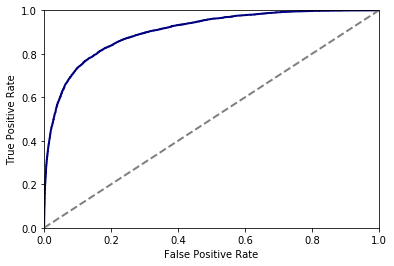

In [105]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(df_test.actual, df_test.probabilities)

plt.plot(fpr, tpr, color='navy', lw=2)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')